In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [3]:
def plot_the_loss_curve(epochs, mse_training, mse_validation):

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.plot(epochs[0:], mse_training[0:], label="Training Loss")
  plt.plot(epochs[0:], mse_validation[0:], label="Validation Loss")
  plt.legend()
  
  # We're not going to plot the first epoch, since the loss on the first epoch
  # is often substantially greater than the loss for other epochs.
  merged_mse_lists = mse_training[1:] + mse_validation[1:]
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
   
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show() 

In [4]:
l_min = 1
l_max = 1

n_l = 1  # defined only one value for L, for now.

# q in kN
q_min = 100
q_max = 500

n_q = 50

# E in GPa
E_min = 100
E_max = 350

n_E = 50

# I in dm^4
I_min = 1 * 10 ** 3 
I_max = 5 * 10 ** 3

n_I = 50

# Will make the vectors linearly spaced, but it's not necessary
l_vec = np.linspace(l_min, l_max, n_l)
q_vec = np.linspace(q_min, q_max, n_q)
E_vec = np.linspace(E_min, E_max, n_E)
I_vec = np.linspace(I_min, I_max, n_I)

In [5]:
# Compute all possible permutations and arrange them in a matrix

# Possibility to add noise to the values of q, E, I.
noise = 0.0

per_list = []
for i in range(len(l_vec)):
    for j in range(len(q_vec)):
        for k in range(len(E_vec)):
            for l in range(len(I_vec)):
                q_vec[j] = q_vec[j] + noise * (np.random.random() - 0.5) * (q_max - q_min)
                E_vec[k] = E_vec[k] + noise * (np.random.random() - 0.5) * (E_max - E_min)
                I_vec[l] = I_vec[l] + noise * (np.random.random() - 0.5) * (I_max - I_min)
                
                per_list = np.append(per_list, np.array([[l_vec[i], q_vec[j], E_vec[k], I_vec[l]]]))

per_list = per_list.reshape(-1, 4)

# Shuffle the permutations
np.random.shuffle(per_list)

np.save('125_combinations', per_list)  # saved as an .npy file to use later using np.load('125_combinations')

In [6]:
# analytical solution for the beam bending problem

def ana_sol(n, param_list):
    l=param_list[0]
    q=param_list[1]
    E=param_list[2]
    I=param_list[3]
    x_min = 0
    x_max = l
    x = np.linspace(x_min, x_max, n)
    y = np.zeros(len(x))
    c_1 = -(q * 10 ** 3 * l ** 3) / (24 * E * 10 ** 9 * I * 10 ** (-8))
    y = (1 / (E * 10 ** 9 * I * 10 ** (-8))) * (((q * 10 ** 3 * l) / 12) * x ** 3 - (q * 10 ** 3 / 24) * x ** 4) + c_1 * x

    return [x, y]

def ana_sol_with_noise(n, param_list,noise):
    l=param_list[0]
    q=param_list[1]
    E=param_list[2]
    I=param_list[3]
    x_min = 0
    x_max = l
    x = np.linspace(x_min, x_max, n)
    y = np.zeros(len(x))
    c_1 = -(q * 10 ** 3 * l ** 3) / (24 * E * 10 ** 9 * I * 10 ** (-8))
    y = (1 / (E * 10 ** 9 * I * 10 ** (-8))) * (((q * 10 ** 3 * l) / 12) * x ** 3 - (q * 10 ** 3 / 24) * x ** 4) + c_1 * x
    y = y + noise * (np.random.random(len(y)) - 0.5) * (np.max(y) - np.min(y))

    return [x, y]

In [134]:
#alternative way to generate fake data with noise
n = 2000
# Add noise
noise_factor = 0.2
#create dictionary with generated data
fake_data = {}
#dict keys: list of parameters values
#dict values: (x,y) array 
for i in per_list:
    fake_data[repr(i.tolist())] = ana_sol_with_noise(n, i, noise_factor)

In [135]:
#for each entry combination of (l,q,E,I) we have two columns of fake data: both x and noisy y 
fake_dataframe=pd.DataFrame.from_dict(fake_data,orient='index',columns=['x', 'y'])
#I will now dstructure the data in such a way that we are able to immediatly assess 
# which entry combination of (l,q,E,I) gives a specific (x,Y)
#let's clean a little
fake_dataframe=fake_dataframe.rename_axis('parameters').reset_index()
fake_dataframe.parameters=[eval(fake_dataframe.parameters[i]) for i in range(len(fake_dataframe))]
fake_dataframe[['l','q','E','I']] = pd.DataFrame(fake_dataframe.parameters.tolist(), index= fake_dataframe.index)
fake_dataframe=fake_dataframe.drop(columns='parameters')
#let's see an example of structured data
fake_dataframe

,x,y,l,q,E,I
0,"[0.0, 0.0005002501250625312, 0.001000500250125...","[-0.00015538554448619543, 1.780500495823041e-0...",1.0,287.755102,217.346939,1000.000000
1,"[0.0, 0.0005002501250625312, 0.001000500250125...","[8.222883821609423e-06, 1.7304429063051407e-05...",1.0,336.734694,283.673469,2224.489796
2,"[0.0, 0.0005002501250625312, 0.001000500250125...","[6.54876387716023e-05, 3.56876099220504e-05, 3...",1.0,328.571429,288.775510,1979.591837
3,"[0.0, 0.0005002501250625312, 0.001000500250125...","[1.987482639569848e-05, 2.4536021721426e-05, -...",1.0,369.387755,151.020408,2551.020408
4,"[0.0, 0.0005002501250625312, 0.001000500250125...","[1.624590070480729e-05, -1.167893773268451e-05...",1.0,320.408163,339.795918,3285.714286
...,...,...,...,...,...,...
124995,"[0.0, 0.0005002501250625312, 0.001000500250125...","[2.456753440783471e-05, 3.650281811127714e-05,...",1.0,222.448980,298.979592,2306.122449
124996,"[0.0, 0.0005002501250625312, 0.001000500250125...","[6.705406018824427e-05, 2.745345186056163e-05,...",1.0,377.551020,186.734694,2959.183673
124997,"[0.0, 0.0005002501250625312, 0.001000500250125...","[-5.415116023139682e-06, -3.57229649028161e-06...",1.0,165.306122,202.040816,3612.244898
124998,"[0.0, 0.0005002501250625312, 0.001000500250125...","[-2.5729436063747564e-05, -8.438751884390667e-...",1.0,165.306122,339.795918,1816.326531


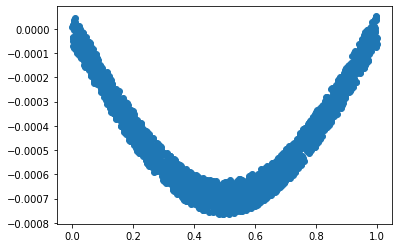

In [136]:
#plot the 1st entry of the dataframe
plt.scatter(fake_dataframe['x'][1],fake_dataframe['y'][1],label=str(fake_dataframe.index[1]))
plt.show()

In [137]:
#with the dataset organized is much easier to split the data.
#https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test
#let's take a look at an example 
test_split=0.1 #we will use 10% of the data for testing. 
df = fake_dataframe
train_df, test_df = train_test_split(df, test_size = test_split)

In [138]:
#the training data will be spllited automatically by 80/20 during training using keras framework. 
# no need to split at this stage.
#let's check the array shapes: 
print('Training set: ',train_df.shape)
print('Test set: ',test_df.shape)

train_size = train_df.shape[0]
test_size = test_df.shape[0]

Training set:  (112500, 6)
Test set:  (12500, 6)


C:\Users\luisf\.conda\envs\tf\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


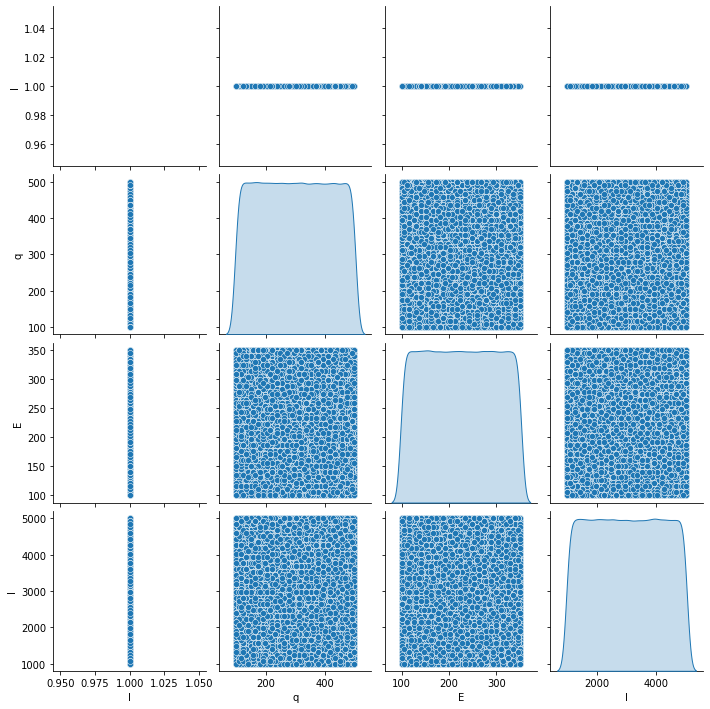

In [139]:
#inspect the training dataset
sns.pairplot(train_df[['l', 'q', 'E', 'I']], diag_kind='kde')

In [140]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
l,112500.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.0
q,112500.0,299.844136,117.830065,100.0,197.959184,295.918367,402.040816,500.0
E,112500.0,224.932018,73.652973,100.0,161.224490,222.448980,288.775510,350.0
I,112500.0,2999.899138,1178.493801,1000.0,1979.591837,2959.183673,4020.408163,5000.0


In [141]:
# follow this tutorial for our data 
# https://www.tensorflow.org/tutorials/keras/regression
# whenever possible, add comments and discussion

In [142]:
# get the max "y" for each entry
df.y.apply(min)
# at this point we could plot very interesting stuff such as ymax distributions on the vars (q,l,E,I)...
# but let's think about that later

0        -0.001887
1        -0.000763
2        -0.000820
3        -0.001371
4        -0.000411
            ...   
124995   -0.000460
124996   -0.000976
124997   -0.000324
124998   -0.000383
124999   -0.000221
Name: y, Length: 125000, dtype: float64

In [143]:
# I have fixed the value of L as 1.0 for now, so I am not using the values of [x,y] as inputs, only the values of y.

In [144]:
# Allocate the features and the labels in different DataFrames.

train_features = train_df.copy()
test_features = test_df.copy()

# train_labels = pd.DataFrame([train_features.pop('l'), train_features.pop('q'), train_features.pop('E'), train_features.pop('I')])
# train_labels = train_labels.T
# test_labels = pd.DataFrame([test_features.pop('l'), test_features.pop('q'), test_features.pop('E'), test_features.pop('I')])
# test_labels = test_labels.T

train_labels = pd.DataFrame([train_features.pop('q'), train_features.pop('E'), train_features.pop('I')])
train_labels = train_labels.T
test_labels = pd.DataFrame([test_features.pop('q'), test_features.pop('E'), test_features.pop('I')])
test_labels = test_labels.T

In [145]:
feature_columns = []

# Will not include the values of x
# x_col = tf.feature_column.numeric_column("x")
# feature_columns.append(x_col)
y_col = tf.feature_column.numeric_column("y")
feature_columns.append(y_col)

my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [146]:
# Build the model and define its architecture.

In [147]:
inputs = keras.Input(shape=n)

In [148]:
dense = layers.Dense(512, activation="relu")
x = dense(inputs)

In [149]:
x = layers.Dense(512, activation="relu")(x)
outputs = layers.Dense(3)(x)

In [150]:
model = keras.Model(inputs=inputs, outputs=outputs, name="model")

In [151]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2000)]            0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1024512   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 1539      
Total params: 1,288,707
Trainable params: 1,288,707
Non-trainable params: 0
_________________________________________________________________


In [152]:
# Set the hyperparameters

validation_split = 0.2
learning_rate = 0.0001
batch_size = 50
epochs = 10

In [153]:
model.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
)

# Still need to find what's the best loss function for our model.

In [154]:
# For some reason I had to manually convert the data into tensors.

tf_train_features = tf.constant([train_features['y']], shape=(train_size,n))

tf_train_labels = tf.constant([np.array(train_labels)], shape=(train_size,3))

tf_test_features = tf.constant([test_features['y']], shape=(test_size,n))

tf_test_labels = tf.constant([np.array(test_labels)], shape=(test_size,3))

In [155]:
history = model.fit(tf_train_features, tf_train_labels, batch_size=batch_size, epochs=epochs, validation_split=validation_split)

test_scores = model.evaluate(tf_train_features, tf_train_labels, verbose=2)
print("Test loss:", test_scores)

Epoch 1/10
1800/1800 [==============================] - 27s 15ms/step - loss: 2676549.5000 - val_loss: 1417165.3750
Epoch 2/10
1800/1800 [==============================] - 26s 14ms/step - loss: 1059431.7500 - val_loss: 765905.0625
Epoch 3/10
1800/1800 [==============================] - 26s 14ms/step - loss: 544132.0000 - val_loss: 376294.8438
Epoch 4/10
1800/1800 [==============================] - 26s 14ms/step - loss: 333895.7812 - val_loss: 316607.0000
Epoch 5/10
1800/1800 [==============================] - 26s 14ms/step - loss: 316441.8125 - val_loss: 313106.8438
Epoch 6/10
1800/1800 [==============================] - 26s 14ms/step - loss: 311390.9062 - val_loss: 305498.6250
Epoch 7/10
1800/1800 [==============================] - 26s 14ms/step - loss: 303163.4062 - val_loss: 298255.3750
Epoch 8/10
1800/1800 [==============================] - 26s 14ms/step - loss: 298243.7188 - val_loss: 295568.8750
Epoch 9/10
1800/1800 [==============================] - 26s 14ms/step - loss: 296426.

765069.28125


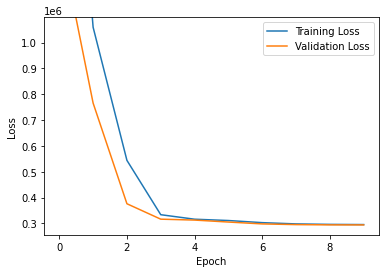

In [156]:
epochs = history.epoch

hist = history.history

plot_the_loss_curve(epochs, hist["loss"], 
                    hist["val_loss"])

In [157]:
tf_test_labels[0:5]

# q; E; I

<tf.Tensor: shape=(5, 3), dtype=float64, numpy=
array([[ 500.        ,  247.95918367, 1653.06122449],
       [ 263.26530612,  176.53061224, 3285.71428571],
       [ 197.95918367,  115.30612245, 5000.        ],
       [ 336.73469388,  288.7755102 , 4755.10204082],
       [ 434.69387755,  309.18367347, 3285.71428571]])>

In [158]:
guesses = model.predict(tf_test_features)

guesses[0:5]

# q; E; I

array([[ 385.9102 ,  168.71208, 1929.094  ],
       [ 294.87564,  237.13104, 3156.7686 ],
       [ 258.43906,  249.63295, 3413.4797 ],
       [ 225.7193 ,  260.83163, 3643.57   ],
       [ 285.7061 ,  240.26408, 3221.1663 ]], dtype=float32)

In [159]:
# relative error (%)

(np.abs(tf_test_labels[0:5] - model.predict(tf_test_features)[0:5]) / tf_test_labels[0:5]) * 100

<tf.Tensor: shape=(5, 3), dtype=float64, numpy=
array([[ 22.81796265,  31.95973651,  16.69827866],
       [ 12.00702638,  34.32856742,   3.92443529],
       [ 30.55168828, 116.4958326 ,  31.73040527],
       [ 32.96820808,   9.6766778 ,  23.37556509],
       [ 34.27418697,  22.29082436,   1.96450514]])>

In [160]:
error_mat = (np.abs(tf_test_labels - model.predict(tf_test_features)) / tf_test_labels) * 100

error_avg = np.array([0,0,0])
error_avg[0] = np.average(error_mat[:,0])
error_avg[1] = np.average(error_mat[:,1])
error_avg[2] = np.average(error_mat[:,2])

error_avg

# average relative error (%) for [q, E, I]

array([32, 28, 31])

In [161]:
def compare_curves(label, guess, n):

    label = [1, label[0], label[1],label[2]]
    guess = [1, guess[0], guess[1], guess[2]]
    
    x_vec = np.linspace(0, 1, n)
    y_vec = ana_sol(n, label)[1] * 10**3  # [mm]

    points = np.zeros((len(x_vec), 2))

    for i in range(len(x_vec)):
        points[i, 0] = x_vec[i]
        points[i, 1] = y_vec[i]
    
    y_vec_g = ana_sol(n, guess)[1] * 10**3  # [mm]

    points = np.zeros((len(x_vec), 2))

    for i in range(len(x_vec)):
        points[i, 0] = x_vec[i]
        points[i, 1] = y_vec[i]


    plt.plot(x_vec, y_vec, c='g')
    plt.plot(x_vec, y_vec_g, c='r')
    plt.show()

In [162]:
# error_col will contain the average of the relative errors (%) for q, E and I for each guess.

error_col = (error_mat[:,0] + error_mat[:,1] + error_mat[:,2])/3

error_col[0:10]

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([23.82532594, 16.75334303, 59.59264205, 22.00681699, 19.50983882,
       70.6112661 , 20.83445835, 28.49778514, 41.16126551,  7.77980405])>

In [163]:
np.average(error_col)

30.77992819787181

In [164]:
np.max(error_col)

160.45245879373434

In [165]:
np.min(error_col)

1.1767152535704148

In [166]:
# Relative errors (%) for q, E, I for our best curve.
np.array(error_mat[np.argmin(error_col),:])

array([1.65378521, 0.1259862 , 1.75037435])

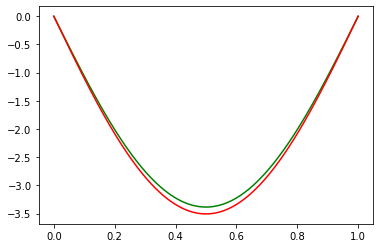

In [167]:
# This is the best guess (the guess which as the minimum average error)
# "True" curve is in green, whereas the "guessed" curve is in red.

min_label = np.array(tf_test_labels[np.argmin(error_col),:])
min_guess = model.predict(tf_test_features)[np.argmin(error_col),:]

compare_curves(min_label, min_guess, n)

In [168]:
# Relative errors (%) for q, E, I for our worst curve.
np.array(error_mat[np.argmax(error_col),:])

array([283.08267212,  72.02397184, 126.25073242])

In [169]:
np.array(tf_test_labels[np.argmax(error_col),:])

array([ 100.        ,  110.20408163, 1000.        ])

In [170]:
model.predict(tf_test_features)[np.argmax(error_col),:]

array([ 383.08267,  189.57744, 2262.5073 ], dtype=float32)

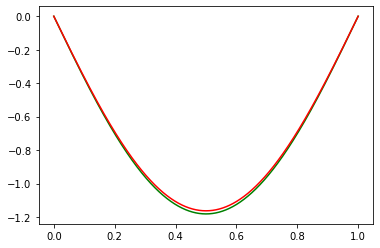

In [171]:
# This is the worst guess (the guess which as the maximum average error)
# "True" curve is in green, whereas the "guessed" curve is in red.

max_label = tf_test_labels[np.argmax(error_col),:]
max_guess = model.predict(tf_test_features)[np.argmax(error_col),:]

compare_curves(max_label, max_guess, n)

The errors for q, E and I (%) are: [5.34005892e-03 2.60946818e+01 4.39620038e+01]


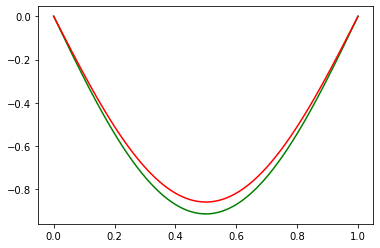

In [172]:
# We can take a look at other curves, for example the curve with less error for q.
i_min_q = np.argmin(error_mat, axis=0)[0]

print('The errors for q, E and I (%) are:', np.array(error_mat[i_min_q,:]))

min_q_label = tf_test_labels[i_min_q,:]
min_q_guess = model.predict(tf_test_features)[i_min_q ,:]

compare_curves(min_q_label, min_q_guess, n)

The errors for q, E and I (%) are: [283.08267212  72.02397184 126.25073242]


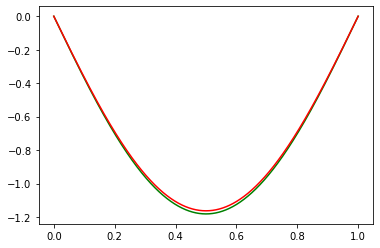

In [173]:
# Or the curve with more error for q.
i_min_q = np.argmax(error_mat, axis=0)[0]

print('The errors for q, E and I (%) are:', np.array(error_mat[i_min_q,:]))

min_q_label = tf_test_labels[i_min_q,:]
min_q_guess = model.predict(tf_test_features)[i_min_q ,:]

compare_curves(min_q_label, min_q_guess, n)

The errors for q, E and I (%) are: [114.4655304  164.68164062  21.71184019]


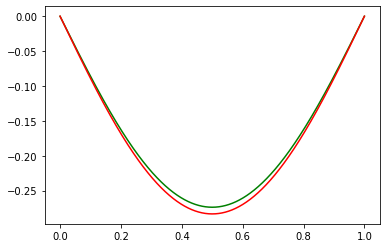

In [174]:
# The curve with more error for E.
i_min_E = np.argmax(error_mat, axis=0)[1]

print('The errors for q, E and I (%) are:', np.array(error_mat[i_min_E,:]))

min_E_label = tf_test_labels[i_min_E,:]
min_E_guess = model.predict(tf_test_features)[i_min_E ,:]

compare_curves(min_E_label, min_E_guess, n)

In [175]:
# We will use the difference between min_y_guessed and min_y_true to evaluate the quality of the curves.

guess_curves = np.zeros([np.size(guesses, 0), n])
true_curves = np.zeros([np.size(guesses, 0), n])

for i in range(np.size(guesses, 0)):
    parameter_list = [1, guesses[i, 0], guesses[i,1], guesses[i,2]]
    guess_curves[i] = ana_sol(n, parameter_list)[1]
    
for i in range(np.size(guesses, 0)):
    true_parameter_list = [1, tf_test_labels[i, 0], tf_test_labels[i,1], tf_test_labels[i,2]]
    true_curves[i] = ana_sol(n, true_parameter_list)[1]
    
delta_y = np.abs(np.min(guess_curves, axis = 1) - np.min(true_curves, axis = 1))

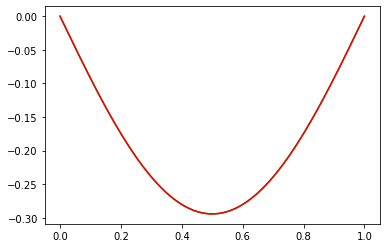

In [176]:
# Using this criteria, this would be our best guess.

i_min_delta = np.argmin(delta_y)
compare_curves(tf_test_labels[i_min_delta,:], model.predict(tf_test_features)[i_min_delta ,:], n)

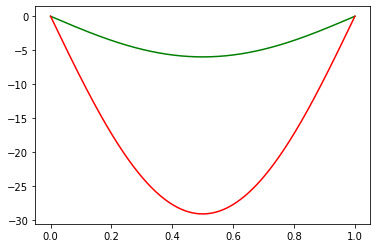

In [177]:
# And this would be our worst

i_max_delta = np.argmax(delta_y)
compare_curves(tf_test_labels[i_max_delta,:], model.predict(tf_test_features)[i_max_delta ,:], n)

In [178]:
# It's probably even better to use the relative error for the minimum value of y to evaluate the quality of the curves.
    
rel_err_y = np.abs(delta_y / np.min(true_curves, axis = 1)) * 100     # (%)

In [179]:
np.average(rel_err_y)

10.501795429121072

In [180]:
np.std(rel_err_y)

12.850865915306331

In [181]:
np.max(rel_err_y)

386.20921118865056

In [182]:
np.min(rel_err_y)

0.011762101350890493

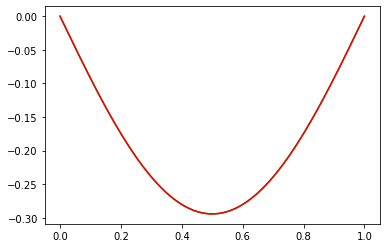

In [183]:
# Best curve

i_min_err = np.argmin(rel_err_y)
compare_curves(tf_test_labels[i_min_err,:], model.predict(tf_test_features)[i_min_err, :], n)

In [184]:
print(np.array(tf_test_labels[i_min_err]))
print(guesses[i_min_err])
print(np.array(error_mat[i_min_err, :]))
print(float(error_col[i_min_err]))
print(rel_err_y[i_min_err])

[ 148.97959184  186.73469388 3530.6122449 ]
[ 219.27637  263.03055 3688.7805 ]
[47.18550674 40.85788914  4.47991061]
30.841102166642003
0.011762101350890493


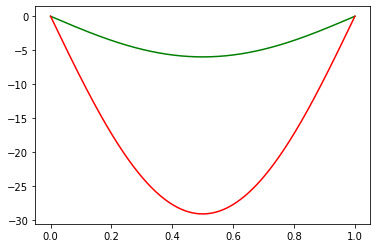

In [185]:
# Worst curve

i_max_err = np.argmax(rel_err_y)
compare_curves(tf_test_labels[i_max_err,:], model.predict(tf_test_features)[i_max_err ,:], n)

In [186]:
print(np.array(tf_test_labels[i_max_err]))
print(guesses[i_max_err])
print(np.array(error_mat[i_max_err, :]))
print(float(error_col[i_max_err]))
print(rel_err_y[i_max_err])

[ 459.18367347  100.         1000.        ]
[477.13452 102.41882 208.66588]
[ 3.90929579  2.41882324 79.13341217]
28.487177067509403
386.20921118865056


In [187]:
# 07/08/2021

# There is no point in trying to guess L in this case, as there is only one value for it.

# Even for multiple values of L, I think that it doesn't make sense to have [x, y] as inputs and at the same time try to 
# guess L, at least in the way I was innitially doing, because, (as the x values are linnearly spaced and allways the same
# for each L), we could easily check the max value of x and get L from that, without any need for a machine learning method.

In [188]:
# 07/08/2021

# Need to improve the way I feed the data to the model (had to extract it from DataFrames and convert the arrays to tensors...)

# Will try to figure out the best loss function, the best architecture for the model,
# tune the hyperparameters and try to get good results.

In [189]:
# 12/09/2021

# I am now only trying to find 3 parameters: E, q and I, as L was set to 1.0.

# After some tunning and experimenting, I'm still not able to say if the problem is with the architecture
# of the model being still too simple, if the problem is with the loss function or if it has to due with
# the lack of normalization of the features. I've noticed that the model is very bad at guessing
# the values for I, which are very small.

In [190]:
# 18/09/2021

# Adjusted the units of q, E and I. This way the values of the loss function don't get too high, they were
# often turning into NaN when I tryed to adjust the model or increase the number of [x,y] inputs.
# This way it is also easier to read the resuts.

In [191]:
# 28/09/2021

# Tried out the model with 64000 combinations. Running time around 3 minutes.
# The average error hasn't gone down, but the curves are apperently much better.
# Even the "worst curve", which for 
# q = 100; E = 112.82051282; I = 1000 guessed
# q = 380.58313; E = 194.59201; I = 2305.1836,
# with an average relative error of 161.2%,
# is quite similar to the true curve, as we can see below.

#compare_curves([100, 112.82051282, 1000], [380.58313, 194.59201, 2305.1836], n)

In [192]:
# 05/10/2021

# Found two interesting curves in one of my runs (Curve 1 and Curve 2 below). Curve 1 has an average relative error
# for the guesses of q, E and I around 27,5% and Curve 2 has an average relative error for the guesses of these values
# of around 20.7% but Curve 1 is my most accurate curve and Curve 2 the least accurate curve if we check the
# relative errors for the minimum values of y:

In [193]:
# Curve 1:

# True label values: q = 366.6666; E = 221.7948; I = 1205.1282
# Guessed values: q = 399.8565; E = 164.7294; I = 1781.4537
# Reletive errors: r.e_q = 9.05%; r.e_E = 25.73%; r.e_I = 47.82%
# Average relative error: 27.53%

# Relative error for delta_min_y: 0.67%

#compare_curves([366.6666, 221.7948, 1205.1282], [399.8565, 164.7294, 1781.4537], n)

In [194]:
# Curve 2:

# True label values: q = 223.07692; E = 260.25641; I = 2435.8974
# Guessed values: q = 261.46088; E = 248.53142; I = 3416.9976 ]
# Reletive errors: r.e_q = 17.21%; r.e_E = 4.51%; r.e_I = 40.28%]
# Average relative error: 20.66%

# Relative error for delta_min_y: 12.50%

#compare_curves([223.07692, 260.25641, 2435.8974], [261.46088, 248.53142, 3416.9976], n)

In [195]:
# 5x5x5 combinations: averages from 5 runs

# Rel. Error for [q, E, I]: [80.4,  32.4,  48.0](%) 

# Average Rel. Error:       54.12%
# Std for Rel. Error:       35.48%
# Max Rel. Error:           141.84
# Min Rel. Error:           9.42%

# Rel. Error for y_min:     44.76%
# Std for y_min:            45.15%
# Max Rel. Error for y_min: 198.66%
# Min Rel. Error for y_min: 5.63%

In [196]:
# 10x10x10 combinations: averages from 5 runs

# Rel. Error for [q, E, I]: [45.6, 32.2, 38.8](%) 
# Average Rel. Error:       39.37%
# Std for Rel. Error:       27.32%
# Max Rel. Error:           138.04%
# Min Rel. Error:           6.18%

# Rel. Error for y_min:     28.24%
# Std for y_min:            29.13%
# Max Rel. Error for y_min: 176.85%
# Min Rel. Error for y_min: 0.67%

In [197]:
# 20x20x20 combinations: averages from 5 runs

# Rel. Error for [q, E, I]: [35.8, 30.6, 33.2](%) 

# Average Rel. Error:        33.66%
# Std for Rel. Error:        23.56%
# Max Rel. Error:            164.70%
# Min Rel. Error:            2.01%

# Rel. Error for y_min:      14.99%
# Std for y_min:             16.00%
# Max Rel. Error for y_min:  155.58%
# Min Rel. Error for y_min:  0.022%

In [198]:
# 30x30x30 combinations: averages from 5 runs

# Rel. Error for [q, E, I]: [33.8, 29.2, 32.6](%) 

# Average Rel. Error:       32.27%
# Std for Rel. Error:       22.81%
# Max Rel. Error:           155.50%
# Min Rel. Error:           1.41%

# Rel. Error for y_min:     10.97%
# Std for y_min:            11.86%
# Max Rel. Error for y_min: 137.99%
# Min Rel. Error for y_min: 0.0078%

In [199]:
# 40x40x40 combinations: averages from 5 runs

# Rel. Error for [q, E, I]: [33.4, 28.2, 31.6](%) 

# Average Rel. Error:       31.56%
# Std for Rel. Error:       21.67%
# Max Rel. Error:           159.13%
# Min Rel. Error:           0.88%

# Rel. Error for y_min:     12.20%
# Std for y_min:            13.67%
# Max Rel. Error for y_min: 156.83%
# Min Rel. Error for y_min: 0.0029%

In [200]:
# 50x50x50 combinations: averages from 3 runs

# Rel. Error for [q, E, I]: [31.7, 27.3, 31.3](%) 

# Average Rel. Error:       30.65%
# Std for Rel. Error:       21.51%
# Max Rel. Error:           160.70%
# Min Rel. Error:           0.97%

# Rel. Error for y_min:     9.18%
# Std for y_min:            9.39%
# Max Rel. Error for y_min: 197.02%
# Min Rel. Error for y_min: 0.00074%

In [201]:
# 60x60x60 combinations: averages from 3 runs

# Rel. Error for [q, E, I]: [31.3, 28.7, 31.0](%) 

# Average Rel. Error:       30.64%
# Std for Rel. Error:       21.85%
# Max Rel. Error:           158.43%
# Min Rel. Error:           0.27%

# Rel. Error for y_min:     8.05%
# Std for y_min:            7.16%
# Max Rel. Error for y_min: 101.50%
# Min Rel. Error for y_min: 0.0019%

In [202]:
# 70x70x70 combinations: averages from 3 runs

# Rel. Error for [q, E, I]: [30.7, 27.6, 31.0](%) 

# Average Rel. Error:       30.26%
# Std for Rel. Error:       21.72%
# Max Rel. Error:           156.45%
# Min Rel. Error:           0.51%

# Rel. Error for y_min:     6.98%
# Std for y_min:            4.94%
# Max Rel. Error for y_min: 87.07%
# Min Rel. Error for y_min: 0.0010%

In [203]:
# 80x80x80 combinations: averages from 3 runs

# Rel. Error for [q, E, I]: [30.3, 27.0, 31.0](%) 

# Average Rel. Error:       29.96%
# Std for Rel. Error:       21.36%
# Max Rel. Error:           155.53%
# Min Rel. Error:           0.58%

# Rel. Error for y_min:     6.02%
# Std for y_min:            3.90%
# Max Rel. Error for y_min: 57.66%
# Min Rel. Error for y_min: 0.00018%